In [334]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display
import textdistance

from data_preprocess import preprocessing

In [341]:
class SEARCH_RECOMMEND:
    
    def __init__(self, df, qval=None):
        self.df = df
        self.qval = qval
        self.df_ = self.preprocess_df(self.df)
    
    def preprocess_df(self, df):
        # make new-tag
        df['new_tag'] = list(
        zip(
            df['top3_style'].tolist(), 
            df['tags'].tolist(),
            df['name'].tolist(),
            df['projectId'].tolist()
            )
        )

        df['new_tag'] = df['new_tag'].apply(self.reduce_newtag)
        df['new_tag'] = df['new_tag'].apply(lambda x: ' '.join(x).lower())
        return df
    
    def reduce_newtag(self, x):
        newtag = []
        for tag in x:
            if type(tag) == str:
                newtag.append(tag)
            else:
                newtag.extend(tag)
        return newtag

    def search_product(self, prod, topn=10, algo='sorensen'):

        # search product tag from input product name
        search_prod_tag = self.df_[self.df_['name'] == prod].sort_values(by='awesome_score', ascending=False)['new_tag'].values[0]

        # calculate similarity
        sim_score = []
        import time
        new_tag = self.df_['new_tag'].tolist()
        start_time = time.time()
        for i, tag in enumerate(new_tag):
            if algo == 'sorensen':
                sim_score.append(textdistance.Sorensen(qval=self.qval, as_set=True).normalized_similarity(search_prod_tag, tag))
            elif algo == 'ncd':
                sim_score.append(textdistance.EntropyNCD(qval=self.qval).normalized_similarity(search_prod_tag, tag))
                

        print(f'검색어 : {search_prod_tag}')
        print(f'검색 시간 : {round(time.time()-start_time, 4)}초')

        # save result
        sim_score = np.asarray(sim_score)
        sim_score_idx = np.arange(len(sim_score))

        result_df = self.df_.iloc[sim_score_idx][['name', 'new_tag', 'projectId', 'images']].reset_index()
        result_df['similarity'] = sim_score
        result_df = result_df.sort_values(by='similarity', ascending=False)

        result_df = result_df[:topn+1]

        # show result image
        print(f'사용자가 선택한 아이템 : {prod}')
        try:
            prod_res = requests.get(self.df_[self.df_['name'] == prod]['images'].values[0][0])
            display(Image.open(BytesIO(prod_res.content)))
        except:
            print('이미지 없음\n')
            print()

        print("="*80)
        print(f"추천 아이템 Top{topn}")
        print("="*80)
        i = 1

        for name, img_url in result_df[['name', 'images']].values:
            if name != prod:
                print(f"추천 {i}순위 : {name}")
                try:
                    res = requests.get(img_url[0])
                    img = Image.open(BytesIO(res.content))
                    display(img)
                except:
                    print('이미지 없음\n')
                print("-"*60)
                i += 1

        self.result = result_df

In [342]:
base_path = '2022-03-07/'
file_paths = [
    base_path + 'bestshots.json', 
    base_path + 'items.json', 
    base_path +'categories.json', 
    base_path +'products.json'
]

In [343]:
products_df_4, products_df_b = preprocessing(file_paths)
products_df_4.shape, products_df_b.shape

/Users/ruo/Desktop/codestates/CP2/data_preprocess.py:37: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  items_stack = pd.DataFrame(templates_df['items'].apply(lambda x: pd.Series(x)).stack()).reset_index(1, drop=True)


((4211, 10), (46576, 10))

In [346]:
search_engine_4 = SEARCH_RECOMMEND(products_df_4, qval=3)

검색어 : modern minimal natural 소파 쇼파 2인용소파 2인소파 2인쇼파 2인 2인용 2인용소파 2인용쇼파 베이지 패브릭 페브릭 2인 2인용 기본형(일자형) 일자형소파 일자형쇼파 일자형 아이와비 토니 토니 2인소파 (베이지) x5dwhwh66e4a3ce37fe4c15
검색 시간 : 0.3663초
사용자가 선택한 아이템 : 토니 2인소파 (베이지)


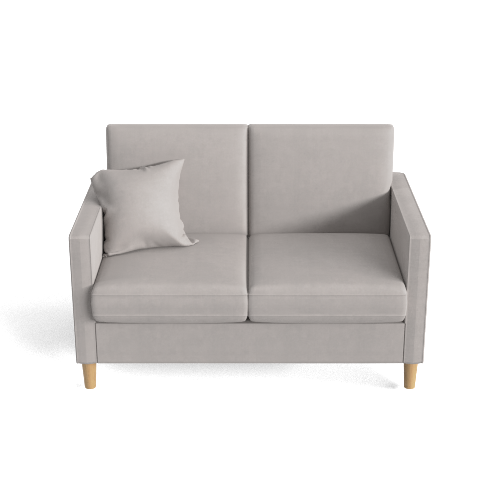

추천 아이템 Top10
추천 1순위 : 세탁가능 VILLE 아쿠아 패브릭소파 2인 (베이지)


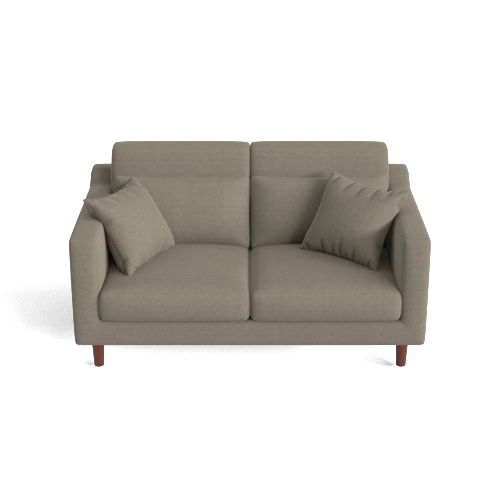

------------------------------------------------------------
추천 2순위 : 베이직 시리즈 DK205 3인용 풀커버 패브릭 발수 소파 베이지


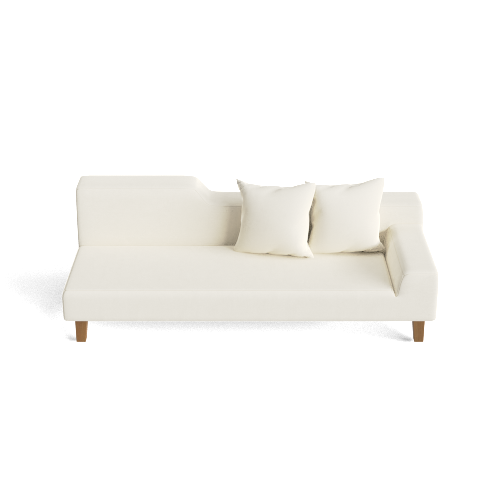

------------------------------------------------------------
추천 3순위 : 세탁가능 VILLE 아쿠아 패브릭소파 2인 (베이지)


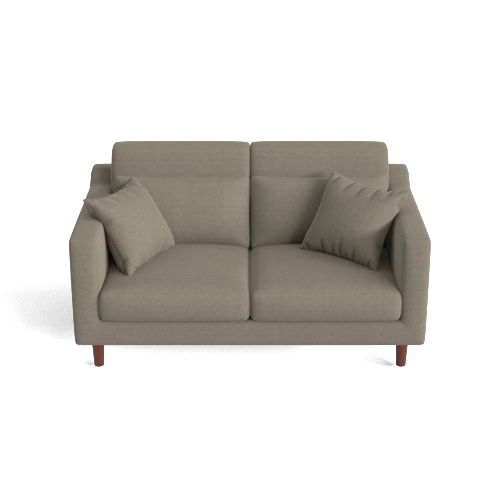

------------------------------------------------------------
추천 4순위 : 두모 2인+스툴세트 스타일클린 워셔블 패브릭소파 (우형) (아이보리)


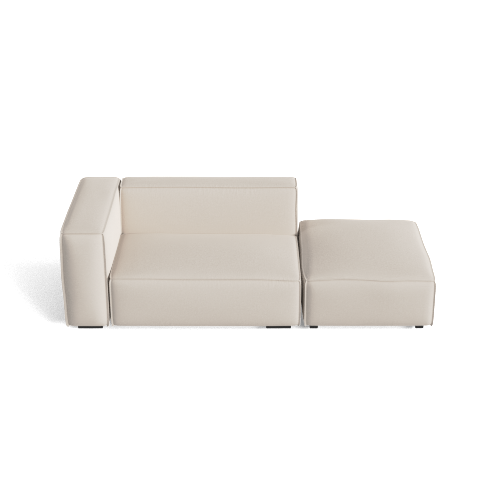

------------------------------------------------------------
추천 5순위 : 밀리노바 서랍수납 침대 Q (화이트)


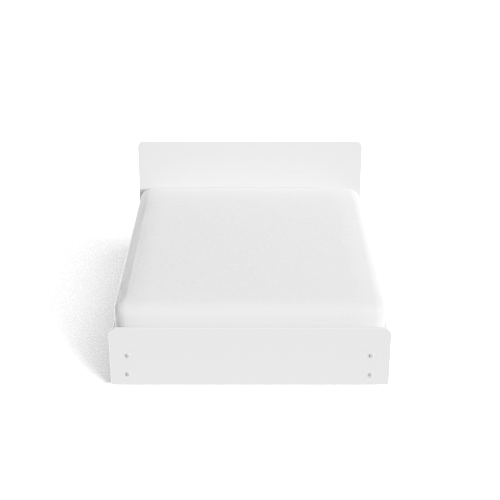

------------------------------------------------------------
추천 6순위 : DK080 3인소파/ 풀커버 패브릭 발수소파 (베이지)


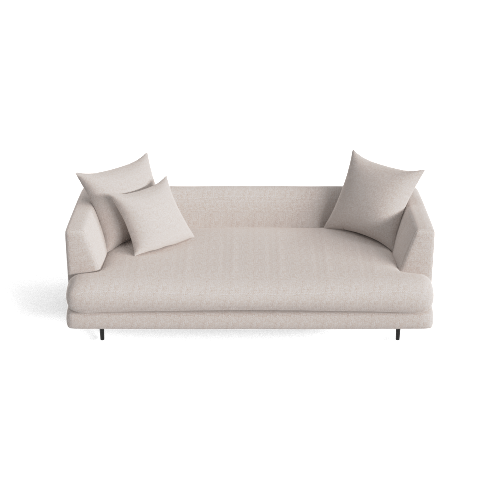

------------------------------------------------------------
추천 7순위 : 마틴 벽시계 (애쉬민트)
이미지 없음

------------------------------------------------------------
추천 8순위 : 메리미 이중레이스 암막커튼 530사이즈 3colors ( 크림베이지 )


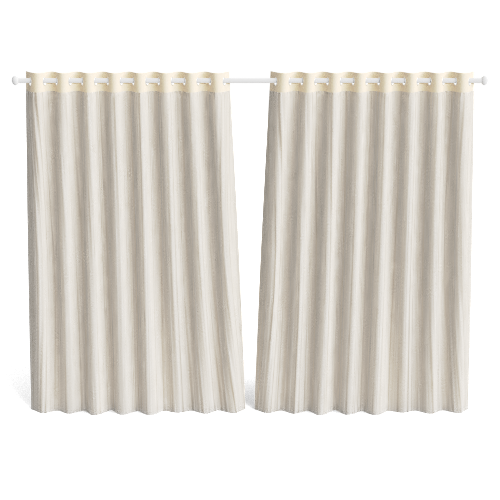

------------------------------------------------------------
추천 9순위 : 코젯 원형 스툴 화장대 의자 SRS001C (연브라운)


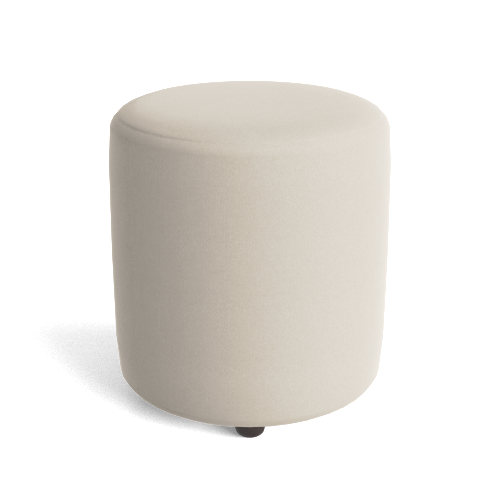

------------------------------------------------------------
추천 10순위 : 킨포크(Kinfolk) Vol. 2


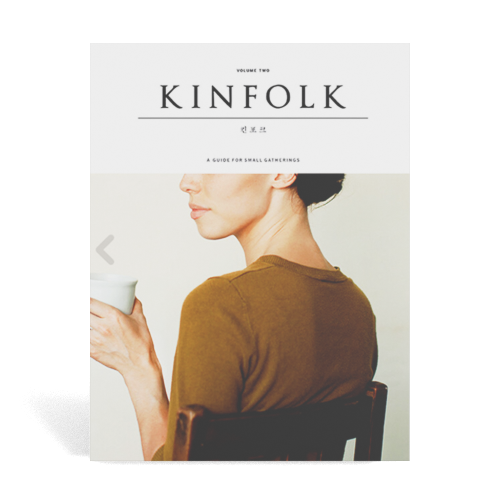

------------------------------------------------------------


In [347]:
prod = "토니 2인소파 (베이지)"
search_engine_4.search_product(prod, topn=10)